<big>**Problem Setup**</big>

We will solve the following $1D$ diffusion-reaction equation:

$$\frac{\partial y}{\partial t}=d\frac{\partial^2y}{\partial x^2}+e^{-t}(3\frac{\sin2x}2+\frac{8\sin3x}3+\frac{15\sin4x}4+\frac{63\sin8x}8)$$

with the initial condition:

$$y(x,0)=\sin x+\frac{\sin2x}2+\frac{\sin3x}3+\frac{\sin4x}4+\frac{\sin8x}8,\quad x\in[-\pi,\pi]$$

and the Dirichlet boundary condition:

$$y(t,-\pi)=y(t,\pi)=0,\quad t\in[0,1]$$

We also specify the following parameters for the equation: 

$$d = 1$$

The exact solution is:

$$y(x,t)=e^{-t}(\sin x+\frac{\sin2x}2+\frac{\sin3x}3+\frac{\sin4x}4+\frac{\sin8x}8)$$

<big>**Implementation**</big>


In [1]:
import deepxde as dde
import numpy as np # type: ignore
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Next, we express the PDE residual of the diffusion-reaction equation:

The first argument to pde is the 2 dimensional vector where the first component x[:, 0] is the $x$-coordinate; and the second component x[:, 1] is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use $y$ as the name of the variable.

In [2]:
def pde(x, y): ##第一个x输入的是一个二维向量，第一个分量指实际的x，第二个分量指的是t
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1
     # Backend pytorch
    return (
        dy_t
        - d * dy_xx
        - torch.exp(-x[:, 1:])
        * (3 * torch.sin(2 * x[:, 0:1]) / 2
           + 8 * torch.sin(3 * x[:, 0:1]) / 3
           + 15 * torch.sin(4 * x[:, 0:1]) / 4
           + 63 * torch.sin(8 * x[:, 0:1]) / 8
        )
    )##和pde相关的变量都用torch来规定

In [3]:
def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )

Now we can define a computational geometry and time domain. We can use a built-in class Interval and TimeDomain and we combine both the domains using GeometryXTime as follows:

In [4]:
geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Now, we have specified the geometry and the PDE residual. We then define the TimePDE problem as:

In [5]:
data = dde.data.TimePDE(
    geomtime, pde, [], num_domain=320, solution=func, num_test=80000
)

The number 320 is the number of training residual points sampled inside the domain, and the number 80000 is the number of points sampled inside the domain for testing the PDE loss.

数字 320 是在域内采样的训练残差点数，数字 80000 是在域内采样的点数，用于测试 PDE 损失。

Next, we choose the network. Here, we use a fully connected neural network of depth 7 (i.e., 6 hidden layers) and width 30:

In [6]:
layer_size = [2] + [30] * 6 + [1] ##[2, 30, 30, 30, 30, 30, 30, 1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Then we construct a function that satisfies both the initial and the boundary conditions to tansform the network output. 

In this case:
$$t(\pi^2-x^2)y+\sin x+\frac{\sin2x}2+\frac{\sin3x}3+\frac{\sin4x}4+\frac{\sin8x}8$$
is used.

If $t$ is equal to 0, the initial condition is recovered. 
$$\sin x+\frac{\sin2x}2+\frac{\sin3x}3+\frac{\sin4x}4+\frac{\sin8x}8,\quad x\in[-\pi,\pi]$$

When $x$ is equal to $\pi$ or $-\pi$, the boundary condition is recovered. 

Hence the initial and boundary conditions are both hard conditions.

In [7]:
# Backend pytorch
def output_transform(x, y):
    return (
        x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
        + torch.sin(x[:, 0:1])
        + torch.sin(2 * x[:, 0:1]) / 2
        + torch.sin(3 * x[:, 0:1]) / 3
        + torch.sin(4 * x[:, 0:1]) / 4
        + torch.sin(8 * x[:, 0:1]) / 8
   )
net.apply_output_transform(output_transform)

Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate. We then train the model for 20000 iterations.

In [8]:
model = dde.Model(data, net)
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-3,
    maxiter=3000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
# model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train()

Compiling model...
'compile' took 1.495453 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.15e+01]    [1.19e+01]    []  
1000      [4.83e-01]    [4.42e-01]    []  
2000      [1.04e-02]    [1.10e-02]    []  
3000      [1.05e-03]    [1.16e-03]    []  

Best model at step 3000:
  train loss: 1.05e-03
  test loss: 1.16e-03
  test metric: []

'train' took 103.304464 s



We also save and plot the best trained result and loss history.

Saving loss history to h:\毕业论文\demo\demo_RD_forward\loss.dat ...
Saving training data to h:\毕业论文\demo\demo_RD_forward\train.dat ...
Saving test data to h:\毕业论文\demo\demo_RD_forward\test.dat ...


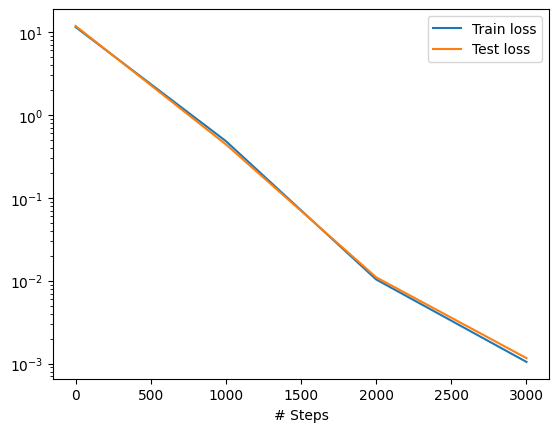

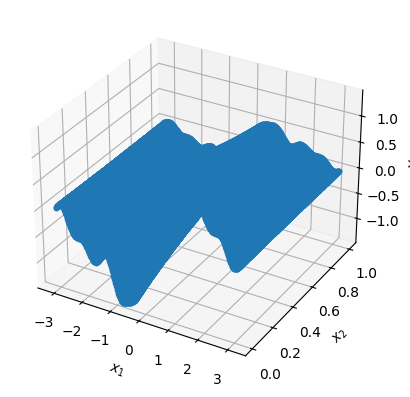

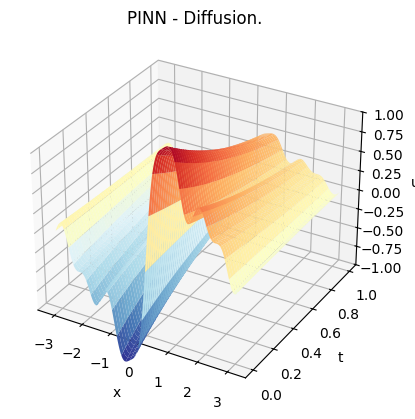

In [9]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt
x = np.linspace(-np.pi, np.pi, 256)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None).reshape(100,256)

x = np.ravel(X).reshape(-1, 1)
t = np.ravel(T).reshape(-1, 1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-1, 1])
ax.plot_surface(X, T, prediction, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('PINN - Diffusion.') 
plt.savefig('Diffusion.png')
plt.show(fig)